# Heimvorteil & Storytelling – 2. Bundesliga

**Ziele**
- Daten aus 1996/97 bis heute laden (alte + neue CSV‑Schemata).
- Heimvorteil **vor / während / nach Corona** quantifizieren.
- **Team‑Profile**: Home vs Away.
- **Aufstieg/Abstieg & Heimstärke**: stärkste Heimteams ohne Aufstieg / schwächste mit Aufstieg.
- **All‑Time**‑Analysen & **zeitliche Trends**.
- Grafiken für die Präsentation exportieren (`../results/`).


In [22]:
# ====================== 0) Setup ======================
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (8,4)
DATA = Path("../data")
RESULTS = Path("../results"); RESULTS.mkdir(exist_ok=True)

# Alle D2-Dateien (alt & neu)
files = sorted(list(DATA.glob("D2_*.csv")))
files


[WindowsPath('../data/D2_18-19.csv'),
 WindowsPath('../data/D2_19-20.csv'),
 WindowsPath('../data/D2_20-21.csv'),
 WindowsPath('../data/D2_21-22.csv'),
 WindowsPath('../data/D2_22-23.csv'),
 WindowsPath('../data/D2_23-24.csv'),
 WindowsPath('../data/D2_24-25.csv'),
 WindowsPath('../data/D2_25-26.csv'),
 WindowsPath('../data/D2_96-97.csv'),
 WindowsPath('../data/D2_97-98.csv'),
 WindowsPath('../data/D2_98-99.csv'),
 WindowsPath('../data/D2_99-00.csv')]

## 1) Laden & Harmonisieren (alte + neue CSVs)

- Alte Dateien (z. B. `D2_96-97.csv`) haben nur Kernspalten:  
  `Div, Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR, HTHG, HTAG, HTR, ...`
- Neue Dateien enthalten viele zusätzliche Spalten (Odds, Stats).  
Hier vereinheitlichen wir auf die **Pflichtspalten** und erzeugen Grundfeatures.


In [23]:
CORE = ["Div","Date","HomeTeam","AwayTeam","FTHG","FTAG","FTR","HTHG","HTAG","HTR"]

def read_flex(path: Path) -> pd.DataFrame:
    # Robust gegen überzählige leere Spalten & Encoding
    df = pd.read_csv(path, encoding="latin-1")
    df.columns = [c.strip() for c in df.columns]
    # Nur Spalten behalten, die existieren
    keep = [c for c in CORE if c in df.columns]
    df = df[keep].copy()
    # Datumsformat (alte Dateien: TT/MM/YY)
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
    # Pflichtfelder sichern
    return df.dropna(subset=["HomeTeam","AwayTeam","FTR","FTHG","FTAG"])

def load_all(paths):
    dfs = [read_flex(p) for p in paths]
    df = pd.concat(dfs, ignore_index=True).sort_values("Date")
    # Saisonlabel (Wechsel 1. Juli)
    def season_from_date(dt):
        y = dt.year
        s = y if dt.month >= 7 else y-1
        return f"{str(s)[-2:]}-{str(s+1)[-2:]}"
    df["Season"] = df["Date"].apply(season_from_date)

    # Punkte (Heim/Auswärts) & Tordifferenz aus Heim-Sicht
    df["HomePoints"] = df["FTR"].map({"H":3,"D":1,"A":0})
    df["AwayPoints"] = df["FTR"].map({"H":0,"D":1,"A":3})
    df["GD"] = df["FTHG"] - df["FTAG"]

    # Laufende Saison (25-26) ausschließen, falls vorhanden
    df["CompletedSeason"] = df["Season"].ne("25-26")
    # Neue Variable: nur ab Saison 2018/19
    df["ModernEra"] = df["Season"].apply(lambda s: int(s.split("-")[0]) >= 18)
    return df

df = load_all(files)
df.head()


C:\Users\admin\AppData\Local\Temp\ipykernel_9224\107660071.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
C:\Users\admin\AppData\Local\Temp\ipykernel_9224\107660071.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
C:\Users\admin\AppData\Local\Temp\ipykernel_9224\107660071.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
C:\Users\admin\AppData\Local

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season,HomePoints,AwayPoints,GD,CompletedSeason,ModernEra
2160,D2,1996-08-02,F Koln,Wolfsburg,2.0,0.0,H,1.0,0.0,H,96-97,3,0,2.0,True,True
2161,D2,1996-08-03,Essen,Stuttgarter K,0.0,4.0,A,0.0,4.0,A,96-97,0,3,-4.0,True,True
2162,D2,1996-08-03,Hertha,Mainz,1.0,0.0,H,0.0,0.0,D,96-97,3,0,1.0,True,True
2163,D2,1996-08-03,Leipzig,Uerdingen,3.0,1.0,H,2.0,0.0,H,96-97,3,0,2.0,True,True
2164,D2,1996-08-03,Zwickau,Mannheim,2.0,0.0,H,1.0,0.0,H,96-97,3,0,2.0,True,True


## 2) Corona‑Phasen laden

Wir lesen `../data/corona_phases.csv` (Semikolon‑getrennt, deutsches Datum).  
Falls die Datei fehlt, definieren wir die Phasen im Code.


In [24]:
ph_path = DATA/"corona_phases.csv"
if ph_path.exists():
    phases = pd.read_csv(ph_path, sep=";", parse_dates=["Start","End"], dayfirst=True)
else:
    phases = pd.DataFrame({
        "Phase":["Pre-Covid","Stop","GhostGames_2019_20","GhostGames_2020_21","PartialFans_2021_22","Post-Covid"],
        "Start":pd.to_datetime(["2018-07-01","2020-03-14","2020-05-16","2020-09-18","2021-08-13","2022-07-01"]),
        "End"  :pd.to_datetime(["2020-03-13","2020-05-15","2020-06-27","2021-05-22","2022-05-14","2025-06-30"])
    })
phases


,Phase,Start,End,Description
0,Pre-Covid,2018-07-01,2020-03-13,"""Normal competition with full attendance"""
1,Stop,2020-03-14,2020-05-15,"""League suspended due to first lockdown"""
2,GhostGames_2019_20,2020-05-16,2020-06-27,"""End of 2019/20 season without fans"""
3,GhostGames_2020_21,2020-09-18,2021-05-22,"""Entire 2020/21 season without fans (rare exce..."
4,PartialFans_2021_22,2021-08-13,2022-05-14,"""2021/22 season with limited or regionally res..."
5,Post-Covid,2022-07-01,2025-06-30,"""Full stadiums, normal competition"""


## 3) Heimvorteil im Kontext von Corona

Wir berechnen **Punkte pro Spiel** (PPG) für Heim- und Auswärtsteams in jeder Phase.


In [25]:
def ppg_by_phase_modern(df, phases):
    rows = []
    data = df[df["ModernEra"]]              # <- nur ab 18-19
    for _, r in phases.iterrows():
        m = data[(data["Date"] >= r["Start"]) & (data["Date"] <= r["End"])]
        if m.empty:
            continue
        rows.append({
            "Phase": r["Phase"],
            "Matches": len(m),
            "HomePPG": m["HomePoints"].mean(),
            "AwayPPG": m["AwayPoints"].mean(),
            "Delta": m["HomePoints"].mean() - m["AwayPoints"].mean()
        })
    return pd.DataFrame(rows)

phase_tab = ppg_by_phase_modern(df, phases)
phase_tab


,Phase,Matches,HomePPG,AwayPPG,Delta
0,Pre-Covid,531,1.549906,1.148776,0.401130
1,GhostGames_2019_20,72,1.666667,1.000000,0.666667
2,GhostGames_2020_21,297,1.582492,1.178451,0.404040
3,PartialFans_2021_22,279,1.458781,1.254480,0.204301
4,Post-Covid,918,1.577342,1.172113,0.405229


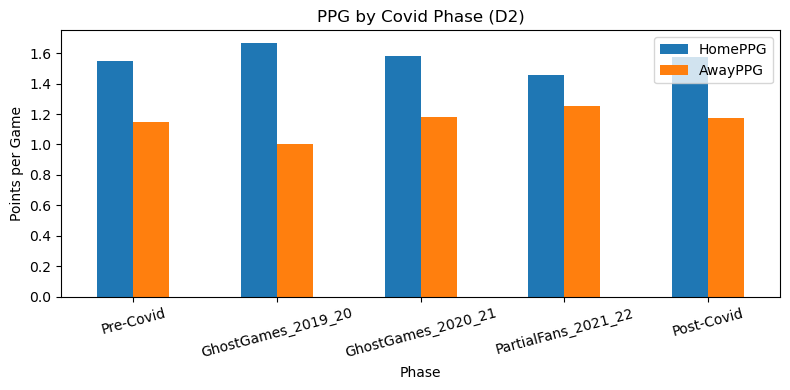

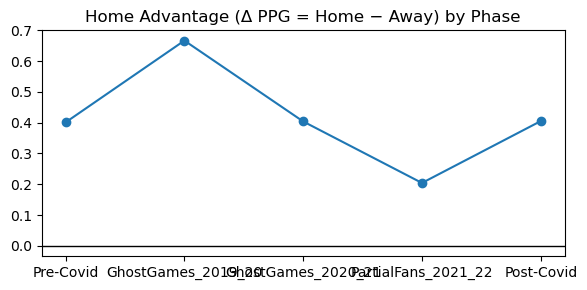

In [26]:
# Plot: Heim- vs Auswärts-PPG je Phase + Delta
fig, ax = plt.subplots(figsize=(8,4))
phase_tab.plot(x="Phase", y=["HomePPG","AwayPPG"], kind="bar", ax=ax, rot=15, title="PPG by Covid Phase (D2)")
plt.ylabel("Points per Game")
plt.tight_layout(); plt.savefig(RESULTS/"ppg_by_covid_phase.png"); plt.show()

plt.figure(figsize=(6,3))
plt.plot(phase_tab["Phase"], phase_tab["Delta"], marker="o")
plt.title("Home Advantage (Δ PPG = Home − Away) by Phase")
plt.axhline(0, color="k", lw=1)
plt.tight_layout(); plt.savefig(RESULTS/"home_advantage_by_phase.png"); plt.show()


## 4) Team‑Profile (Home vs Away) – Diverging Chart

Divergierende Balken: **Home** nach links (rot), **Away** nach rechts (blau).  
Teams nach **Endplatzierung** sortiert (1 oben).


C:\Users\admin\AppData\Local\Temp\ipykernel_9224\2342158020.py:27: UserWarning: Glyph 159 (\x9f) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.savefig(RESULTS/f"diverging_{season}.png"); plt.show()
c:\Users\admin\.conda\envs\mini-projekt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 159 (\x9f) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


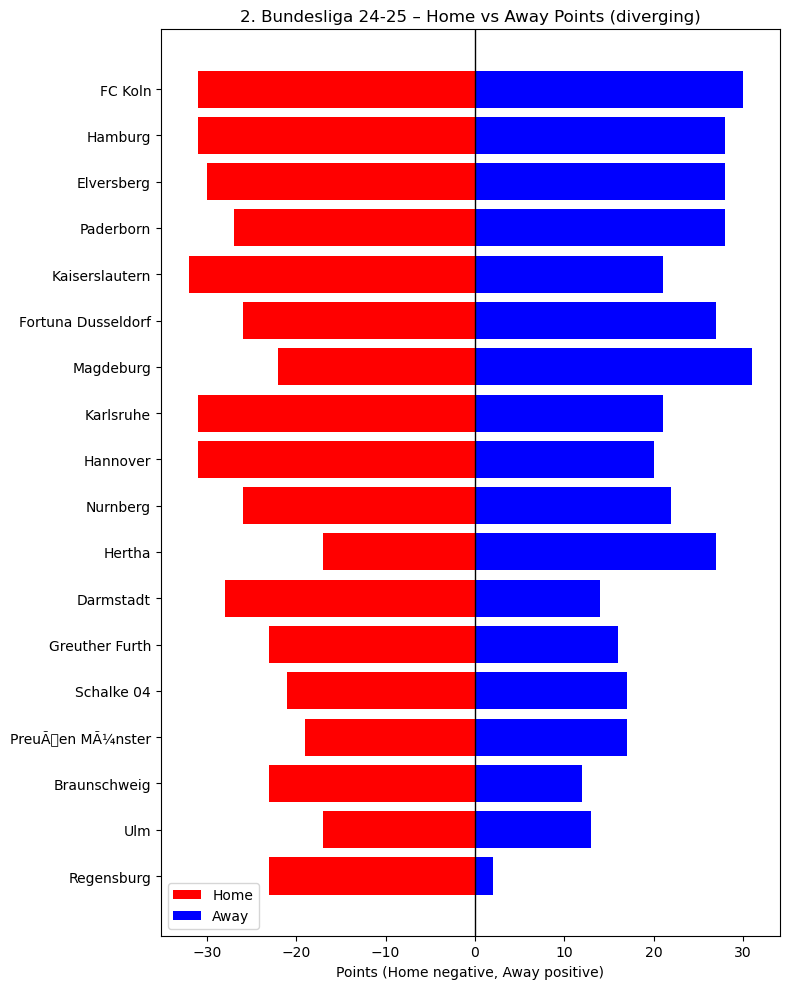

In [27]:
def season_points_home_away(df, season):
    d = df[df["Season"]==season]
    # Heim/Auswärts-Punkte
    home = d.groupby("HomeTeam")["FTR"].apply(lambda s: (s=="H").sum()*3 + (s=="D").sum()).reset_index(name="HomePts")
    away = d.groupby("AwayTeam")["FTR"].apply(lambda s: (s=="A").sum()*3 + (s=="D").sum()).reset_index(name="AwayPts")
    # Gesamttabelle (für Pos)
    long = pd.concat([
        pd.DataFrame({"Team": d["HomeTeam"], "Pts": d["FTR"].map({"H":3,"D":1,"A":0}).astype(int)}),
        pd.DataFrame({"Team": d["AwayTeam"], "Pts": d["FTR"].map({"A":3,"D":1,"H":0}).astype(int)}),
    ])
    table = long.groupby("Team")["Pts"].sum().reset_index().sort_values("Pts", ascending=False).reset_index(drop=True)
    table["Pos"] = table.index + 1
    return table.merge(home, left_on="Team", right_on="HomeTeam", how="left").merge(
        away, left_on="Team", right_on="AwayTeam", how="left"
    )[["Pos","Team","HomePts","AwayPts"]].sort_values("Pos")

def plot_diverging(df, season):
    t = season_points_home_away(df, season).set_index("Team")
    fig, ax = plt.subplots(figsize=(8,10))
    ax.barh(t.index, -t["HomePts"], label="Home", color="red")
    ax.barh(t.index,  t["AwayPts"], label="Away", color="blue")
    ax.axvline(0, color="black", lw=1)
    ax.invert_yaxis()
    ax.set_title(f"2. Bundesliga {season} – Home vs Away Points (diverging)")
    ax.set_xlabel("Points (Home negative, Away positive)")
    ax.legend()
    plt.tight_layout(); plt.savefig(RESULTS/f"diverging_{season}.png"); plt.show()

# Beispiel: letzte abgeschlossene Saison (falls 24-25 abgeschlossen; sonst 23-24)
target_season = sorted(df[df["CompletedSeason"]]["Season"].unique())[-1]
plot_diverging(df, "24-25")


## 5) Aufstieg / Abstieg & Heimstärke

Pro Saison:
- **Stärkste Heimmannschaft, die nicht in der Aufstiegszone** landet.  
- **Schwächste Heimmannschaft innerhalb der Aufstiegszone** (Standard: Platz 1–2).


In [28]:
def season_full_table(df, season):
    d = df[df["Season"]==season]
    home = pd.DataFrame({"Team": d["HomeTeam"], "Pts": d["FTR"].map({"H":3,"D":1,"A":0}).astype(int)})
    away = pd.DataFrame({"Team": d["AwayTeam"], "Pts": d["FTR"].map({"A":3,"D":1,"H":0}).astype(int)})
    tab = pd.concat([home,away]).groupby("Team", as_index=False).sum()
    tab = tab.sort_values("Pts", ascending=False).reset_index(drop=True)
    tab["Pos"] = tab.index + 1
    return tab

def season_home_ppg(df, season):
    d = df[df["Season"]==season]
    h = d.groupby("HomeTeam").agg(HomePts=("FTR", lambda s: (s=="H").sum()*3 + (s=="D").sum()),
                                  HMP=("FTR","count")).reset_index()
    h["PPG_H"] = h["HomePts"]/h["HMP"]
    return h.rename(columns={"HomeTeam":"Team"})[["Team","PPG_H"]]

def promotion_home_outliers(df, season, promoted_slots=2):
    full = season_full_table(df, season)
    home = season_home_ppg(df, season)
    m = full.merge(home, on="Team", how="left")
    strongest_non = m[m["Pos"]>promoted_slots].sort_values("PPG_H", ascending=False).head(1)
    weakest_prom  = m[m["Pos"]<=promoted_slots].sort_values("PPG_H", ascending=True).head(1)
    return strongest_non.assign(Season=season, Type="BestHome_NotPromoted"), \
           weakest_prom.assign(Season=season, Type="WorstHome_Promoted")

rows=[]
for s in sorted(df[df["CompletedSeason"]]["Season"].unique()):
    a,b = promotion_home_outliers(df, s, promoted_slots=2)
    rows += [a,b]
promo_summary = pd.concat(rows, ignore_index=True)[["Season","Type","Pos","Team","PPG_H"]]
promo_summary.head(10)


,Season,Type,Pos,Team,PPG_H
0,18-19,BestHome_NotPromoted,3,Union Berlin,2.235294
1,18-19,WorstHome_Promoted,1,FC Koln,1.764706
2,19-20,BestHome_NotPromoted,3,Heidenheim,2.176471
3,19-20,WorstHome_Promoted,1,Bielefeld,2.000000
4,20-21,BestHome_NotPromoted,5,Fortuna Dusseldorf,2.176471
5,20-21,WorstHome_Promoted,2,Greuther Furth,1.823529
6,21-22,BestHome_NotPromoted,5,St Pauli,2.176471
7,21-22,WorstHome_Promoted,2,Werder Bremen,1.764706
8,22-23,BestHome_NotPromoted,4,Fortuna Dusseldorf,2.176471
9,22-23,WorstHome_Promoted,2,Darmstadt,2.235294


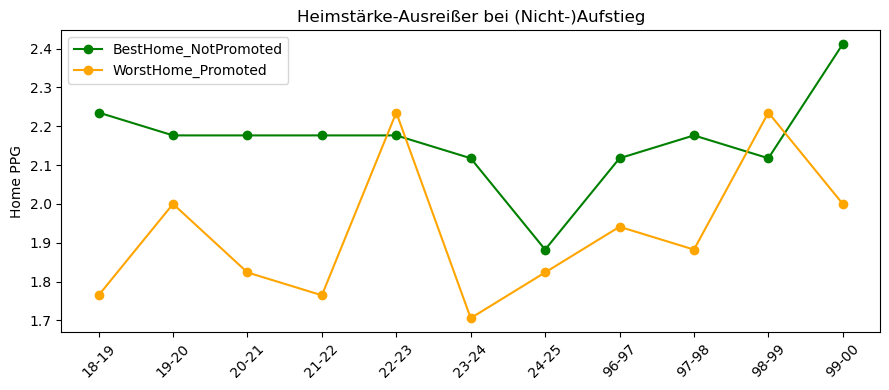

In [29]:
# Plot Übersicht der "Ausreißer" über die Jahre
fig, ax = plt.subplots(figsize=(9,4))
for typ, col in [("BestHome_NotPromoted","green"), ("WorstHome_Promoted","orange")]:
    tmp = promo_summary[promo_summary["Type"]==typ]
    ax.plot(tmp["Season"], tmp["PPG_H"], marker="o", label=typ, color=col)
plt.xticks(rotation=45); plt.ylabel("Home PPG")
plt.title("Heimstärke-Ausreißer bei (Nicht‑)Aufstieg")
plt.legend(); plt.tight_layout(); plt.savefig(RESULTS/"promo_home_outliers.png"); plt.show()


## 6) All‑Time Tabellen (Home/Away/Overall)

Wir aggregieren alle Saisons (ohne laufende) auf Teamebene.


In [30]:
# long-Format aller Spiele: Heim- / Auswärtssicht
def long_results(df):
    home = pd.DataFrame({"Team": df["HomeTeam"], "GF": df["FTHG"], "GA": df["FTAG"],
                         "Pts": df["FTR"].map({"H":3,"D":1,"A":0}).astype(int), "MP":1, "Side":"Home"})
    away = pd.DataFrame({"Team": df["AwayTeam"], "GF": df["FTAG"], "GA": df["FTHG"],
                         "Pts": df["FTR"].map({"A":3,"D":1,"H":0}).astype(int), "MP":1, "Side":"Away"})
    return pd.concat([home,away], ignore_index=True)

df_done = df[df["CompletedSeason"]].copy()
L = long_results(df_done)

alltime = L.groupby("Team", as_index=False).sum(numeric_only=True)
alltime["GD"] = alltime["GF"] - alltime["GA"]
alltime["PPG"] = alltime["Pts"]/alltime["MP"]
alltime = alltime.sort_values(["Pts","GD","GF"], ascending=[False,False,False]).reset_index(drop=True)
alltime.head(10)


,Team,GF,GA,Pts,MP,GD,PPG
0,St Pauli,445.0,402.0,459,306,43.0,1.500000
1,Greuther Furth,406.0,405.0,420,306,1.0,1.372549
2,Hamburg,457.0,300.0,411,238,157.0,1.726891
3,Hannover,400.0,376.0,380,272,24.0,1.397059
4,Nurnberg,381.0,409.0,373,272,-28.0,1.371324
5,Karlsruhe,420.0,410.0,366,272,10.0,1.345588
6,Darmstadt,333.0,285.0,318,204,48.0,1.558824
7,Paderborn,363.0,283.0,317,204,80.0,1.553922
8,Holstein Kiel,339.0,296.0,313,204,43.0,1.534314
9,Heidenheim,259.0,211.0,280,170,48.0,1.647059


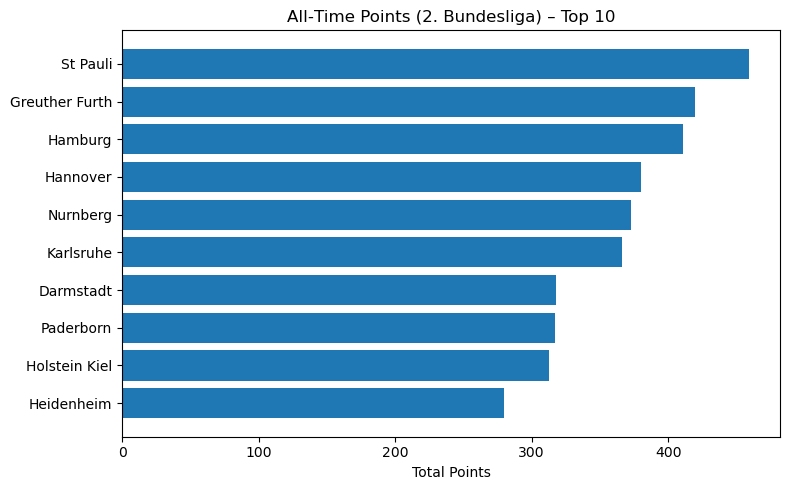

In [31]:
# Top 10 All-Time (Overall) – Plot
top10 = alltime.head(10).sort_values("Pts")
fig, ax = plt.subplots(figsize=(8,5))
ax.barh(top10["Team"], top10["Pts"])
ax.set_title("All‑Time Points (2. Bundesliga) – Top 10")
ax.set_xlabel("Total Points")
plt.tight_layout(); plt.savefig(RESULTS/"alltime_top10_points.png"); plt.show()


## 7) Zeitliche Trends (seit 1996/97)

Ø‑Punkte/Spiel und Ø‑Tore Heim/Auswärts je Saison – zeigt langfristige Veränderungen des Heimvorteils.


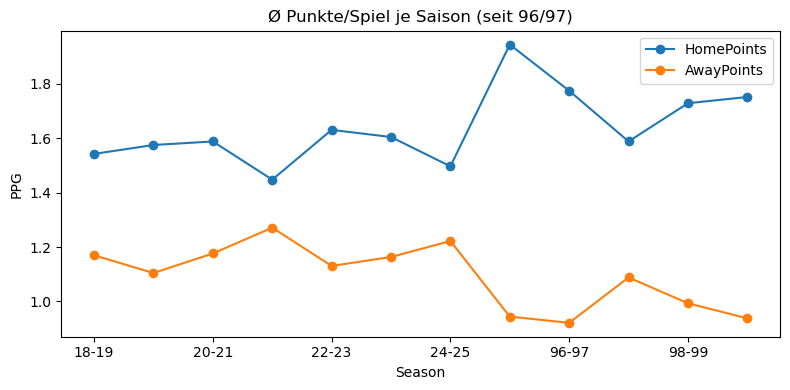

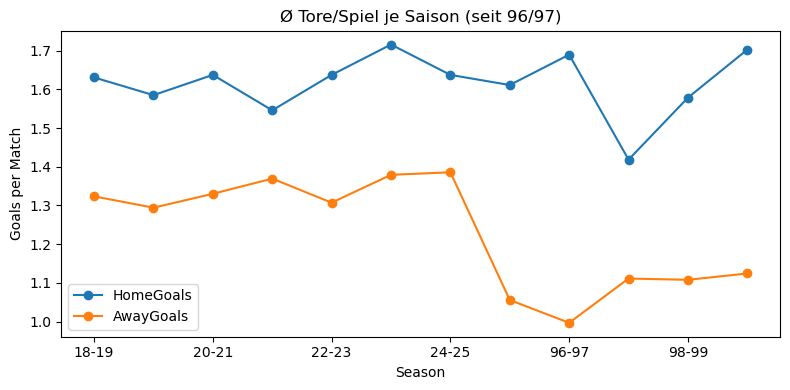

In [32]:
season_ppg = df.groupby("Season")[["HomePoints","AwayPoints"]].mean()
ax = season_ppg.plot(marker="o", title="Ø Punkte/Spiel je Saison (seit 96/97)")
plt.ylabel("PPG"); plt.tight_layout(); plt.savefig(RESULTS/"ppg_by_season_long.png"); plt.show()

season_goals = df.groupby("Season")[["FTHG","FTAG"]].mean().rename(columns={"FTHG":"HomeGoals","FTAG":"AwayGoals"})
ax = season_goals.plot(marker="o", title="Ø Tore/Spiel je Saison (seit 96/97)")
plt.ylabel("Goals per Match"); plt.tight_layout(); plt.savefig(RESULTS/"goals_by_season_long.png"); plt.show()


## 8) Visual Storytelling

1. **These**: Heimvorteil existiert, wurde durch **Geisterspiele** gedämpft und kehrte mit Fans zurück.  
   → *Charts:* `ppg_by_covid_phase.png`, `home_advantage_by_phase.png`

2. **Ligaweit**: Langfristige Entwicklung (seit 96/97).  
   → *Charts:* `ppg_by_season_long.png`, `goals_by_season_long.png`

3. **Team‑Profile**: Wer lebt von Heim-, wer von Auswärtspunkten?  
   → *Chart:* `diverging_{SEASON}.png` (z. B. aktuelle abgeschlossene Saison)

4. **Aufstieg/Abstieg**: Heimstärke‑Ausreißer.  
   → *Chart:* `promo_home_outliers.png` + 1–2 Beispiele (Tabellenzeilen)

5. **All‑Time**: Historischer Kontext.  
   → *Chart:* `alltime_top10_points.png`


## 9) Exports

Die wichtigsten Tabellen als CSV für spätere Folien.


In [33]:
phase_tab.to_csv(RESULTS/"covid_phases_ppg.csv", index=False)
alltime.to_csv(RESULTS/"alltime_overall_points.csv", index=False)

# Beispiel: Saison-Tabelle & Diverging-Daten der Ziel-Saison
t = season_points_home_away(df, target_season)
t.to_csv(RESULTS/f"home_away_points_{target_season}.csv", index=False)
